# Optimizing mining operations

This tutorial includes everything you need to set up IBM Decision Optimization CPLEX Modeling for Python (DOcplex), build a Mathematical Programming model, and get its solution by solving the model on Cloud with IBM ILOG CPLEX Optimizer.

When you finish this tutorial, you'll have a foundational knowledge of _Prescriptive Analytics_.

>This notebook is part of [Prescriptive Analytics for Python](http://ibmdecisionoptimization.github.io/docplex-doc/)
>
>It requires either an [installation of CPLEX Optimizers](http://ibmdecisionoptimization.github.io/docplex-doc/getting_started.html) or it can be run on [IBM Cloud Pak for Data as a Service](https://www.ibm.com/products/cloud-pak-for-data/as-a-service/) (Sign up for a [free IBM Cloud account](https://dataplatform.cloud.ibm.com/registration/stepone?context=wdp&apps=all>)
and you can start using `IBM Cloud Pak for Data as a Service` right away).
>
> CPLEX is available on <i>IBM Cloud Pack for Data</i> and <i>IBM Cloud Pak for Data as a Service</i>:
>    - <i>IBM Cloud Pak for Data as a Service</i>: Depends on the runtime used:
>         - <i>Python 3.x</i> runtime: Community edition
>         - <i>Python 3.x + DO</i> runtime: full edition
>    - <i>Cloud Pack for Data</i>: Community edition is installed by default. Please install `DO` addon in `Watson Studio Premium` for the full edition


Table of contents:

-  [Describe the business problem](#Describe-the-business-problem)
*  [How decision optimization (prescriptive analytics) can help](#How--decision-optimization-can-help)
*  [Use decision optimization](#Use-decision-optimization)
    *  [Step 1: Import the library](#Step-1:-Import-the-library)
    -  [Step 2: Model the data](#Step-2:-Model-the-data)
    *  [Step 3: Prepare the data](#Step-3:-Prepare-the-data)
    -  [Step 4: Set up the prescriptive model](#Step-4:-Set-up-the-prescriptive-model)
        * [Define the decision variables](#Define-the-decision-variables)
        * [Express the business constraints](#Express-the-business-constraints)
        * [Express the objective](#Express-the-objective)
        * [Solve with Decision Optimization](#Solve-with-Decision-Optimization)
    *  [Step 5: Investigate the solution and run an example analysis](#Step-5:-Investigate-the-solution-and-then-run-an-example-analysis)
*  [Summary](#Summary)

****

## Describe the business problem

This mining operations optimization problem is an implementation of Problem 7 from "Model Building in Mathematical Programming" by
H.P. Williams. 
The operational decisions that need to be made are which mines should be operated each year and
how much each mine should produce.


### Business constraints

 * A mine that is closed cannot be worked.
 * Once closed, a mine stays closed until the end of the horizon.
 * Each year, a maximum number of mines can be worked.
 * For each mine and year, the quantity extracted is limited by the mine's maximum extracted quantity.
 * The average blend quality must be greater than or equal to the requirement of the year.
 
### Objective and KPIs

#### Total actualized  revenue

Each year, the total revenue is equal to the total quantity extracted multiplied by the blend price. The time series of revenues is aggregated in one expected revenue by applying the discount rate; in other terms, a revenue of \$1000 next year is counted as \$900 actualized, \$810 if the revenue is expected in two years, etc.

#### Total expected royalties

A mine that stays open must pay royalties (see the column **royalties** in the DataFrame). Again, royalties from different years are actualized using the discount rate.

#### Business objective

The business objective is to maximize the net actualized profit, that is the difference between the total actualized revenue and total actualized royalties.

## How  decision optimization can help

* Prescriptive analytics (decision optimization) technology recommends actions that are based on desired outcomes.  It takes into account specific scenarios, resources, and knowledge of past and current events. With this insight, your organization can make better decisions and have greater control of business outcomes.  

* Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  

* Prescriptive analytics takes that insight to the next level by suggesting the optimal way to handle that future situation. Organizations that can act fast in dynamic conditions and make superior decisions in uncertain environments gain a strong competitive advantage.  
<br/>

<u>With prescriptive analytics, you can:</u> 

* Automate the complex decisions and trade-offs to better manage your limited resources.
* Take advantage of a future opportunity or mitigate a future risk.
* Proactively update recommendations based on changing events.
* Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes.

## Checking minimum requirements
This notebook uses some features of pandas that are available in version 0.17.1 or above.

In [1]:
import pip
REQUIRED_MINIMUM_PANDAS_VERSION = '0.17.1'
try:
    import pandas as pd
    assert pd.__version__ >= REQUIRED_MINIMUM_PANDAS_VERSION
except:
    raise Exception("Version %s or above of Pandas is required to run this notebook" % REQUIRED_MINIMUM_PANDAS_VERSION)

## Use decision optimization

### Step 1: Import the library

Run the following code to import the Decision Optimization CPLEX Modeling library.  The *DOcplex* library contains the two modeling packages, Mathematical Programming and Constraint Programming, referred to earlier.

In [2]:
import sys
try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')

If *CPLEX* is not installed, you can install CPLEX Community edition.

In [3]:
try:
    import cplex
except:
    raise Exception('Please install CPLEX. See https://pypi.org/project/cplex/')

### Step 2: Model the data
#### Mining Data

The mine data is provided as a *pandas* DataFrame. For each mine, we are given the amount of royalty to pay when operating the mine, its ore quality, and the maximum quantity that we can extract from the mine.


In [4]:
# If needed, install the module pandas prior to executing this cell
import pandas as pd
from pandas import DataFrame, Series

In [5]:
df_mines = DataFrame({"royalties":   [ 5  ,   4,   4, 5  ],
                      "ore_quality": [ 1.0, 0.7, 1.5, 0.5],
                      "max_extract": [ 2  , 2.5, 1.3, 3  ]})
nb_mines = len(df_mines)
df_mines.index.name='range_mines'
df_mines

,royalties,ore_quality,max_extract
range_mines,,,
0,5,1.0,2.0
1,4,0.7,2.5
2,4,1.5,1.3
3,5,0.5,3.0


#### Blend quality data

Each year, the average blend quality of all ore extracted from the mines
must be greater than a minimum quality. This data is provided as a *pandas* Series, the length of which is the plan horizon in years.

In [6]:
blend_qualities = Series([0.9, 0.8, 1.2, 0.6, 1.0])
nb_years = len(blend_qualities)
print("* Planning mining operations for: {} years".format(nb_years))
blend_qualities.describe()

* Planning mining operations for: 5 years


count    5.000000
mean     0.900000
std      0.223607
min      0.600000
25%      0.800000
50%      0.900000
75%      1.000000
max      1.200000
dtype: float64

#### Additional (global) data

We need extra global data to run our planning model:

 * a blend price (supposedly flat),
 * a maximum number of worked mines for any given years (typically 3), and
 * a discount rate to compute the actualized revenue over the horizon.
 

In [7]:
# global data
blend_price = 10
max_worked_mines = 3  # work no more than 3 mines each year
discount_rate = 0.10  # 10% interest rate each year

### Step 3: Prepare the data
The data is clean and does not need any cleansing.

### Step 4: Set up the prescriptive model

#### Create DOcplex model
The model contains all the business constraints and defines the objective.

In [8]:
from docplex.mp.model import Model

mm = Model("mining_pandas")

What are the decisions we need to make?

 * What mines do we work each year? (a yes/no decision)
 * What mine do we keep open each year? (again a yes/no decision)
 * What quantity is extracted from each mine, each year? (a positive number)
 
 We need to define some decision variables and add constraints to our model related to these decisions.
 

#### Define the decision variables

In [9]:
# auxiliary data: ranges
range_mines = range(nb_mines)
range_years = range(nb_years)

# binary decisions: work the mine or not
work_vars  = mm.binary_var_matrix(keys1=range_mines, keys2=range_years, name='work')
# open the mine or not
open_vars  = mm.binary_var_matrix(range_mines, range_years, name='open')
# quantity to extract
ore_vars   = mm.continuous_var_matrix(range_mines, range_years, name='ore')
mm.print_information()

Model: mining_pandas
 - number of variables: 60
   - binary=40, integer=0, continuous=20
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: MILP


#### Express the business constraints
##### Constraint 1: Only open mines can be worked.
In order to take advantage of the *pandas* operations to create the optimization model, decision variables are organized in a DataFrame which is automatically indexed by *'range_mines'* and *'range_years'* (that is, the same keys as the dictionary created by the *binary_var_matrix()* method).

In [10]:
# Organize all decision variables in a DataFrame indexed by 'range_mines' and 'range_years'
df_decision_vars = DataFrame({'work': work_vars, 'open': open_vars, 'ore': ore_vars})
# Set index names
df_decision_vars.index.names=['range_mines', 'range_years']

# Display rows of 'df_decision_vars' DataFrame for first mine
df_decision_vars[:nb_years]

work      open      ore
range_mines range_years                             
0           0            work_0_0  open_0_0  ore_0_0
            1            work_0_1  open_0_1  ore_0_1
            2            work_0_2  open_0_2  ore_0_2
            3            work_0_3  open_0_3  ore_0_3
            4            work_0_4  open_0_4  ore_0_4

Now, let's iterate over rows of the DataFrame *"df_decision_vars"* and enforce the desired constraints.

The *pandas* method *itertuples()* returns a named tuple for each row of a DataFrame. This method is efficient and convenient for iterating over all rows.

In [11]:
mm.add_constraints(t.work <= t.open for t in df_decision_vars.itertuples())
mm.print_information()

Model: mining_pandas
 - number of variables: 60
   - binary=40, integer=0, continuous=20
 - number of constraints: 20
   - linear=20
 - parameters: defaults
 - objective: none
 - problem type is: MILP


##### Constraint 2: Once closed, a mine stays closed.

These constraints are a little more complex: we state that the series of *open_vars[m,y]* for a given mine *_m_* is decreasing. In other terms, once some *open_vars[m,y]* is zero, all subsequent values for future years are also zero.

Let's use the *pandas* *groupby* operation to collect all *"open"* decision variables for each mine in separate *pandas* Series.<br>
Then, we iterate over the mines and invoke the *aggregate()* method, passing the *postOpenCloseConstraint()* function as the argument.<br>
The *pandas* *aggregate()* method invokes *postOpenCloseConstraint()* for each mine, passing the associated Series of *"open"* decision variables as argument.
The *postOpenCloseConstraint()* function posts a set of constraints on the sequence of *"open"* decision variables to enforce that a mine cannot re-open.

In [12]:
# Once closed, a mine stays closed
def postOpenCloseConstraint(open_vars):
    mm.add_constraints(open_next <= open_curr
                      for (open_next, open_curr) in zip(open_vars[1:], open_vars))
    # Optionally: return a string to display information regarding the aggregate operation in the Output cell
    return "posted {0} open/close constraints".format(len(open_vars) - 1)

# Constraints on sequences of decision variables are posted for each mine, 
# using pandas' "groupby" operation.
df_decision_vars.open.groupby(level='range_mines').aggregate(postOpenCloseConstraint)

range_mines
0    posted 4 open/close constraints
1    posted 4 open/close constraints
2    posted 4 open/close constraints
3    posted 4 open/close constraints
Name: open, dtype: object

##### Constraint 3: The number of worked mines each year is limited.

This time, we use the *pandas* *groupby* operation to collect all *"work"* decision variables for each **year** in separate *pandas* Series. Each Series contains the *"work"* decision variables for all mines.
Then, the maximum number of worked mines constraint is enforced by making sure that the sum of all the terms of each Series is smaller or equal to the maximum number of worked mines.<br>
The *aggregate()* method is used to post this constraint for each *year*.

In [13]:
# Maximum number of worked mines each year
# Note that Model.sum() accepts a pandas Series of variables.
df_decision_vars.work.groupby(level='range_years').aggregate(
    lambda works: mm.add_constraint(mm.sum(works) <= max_worked_mines))

range_years
0    work_0_0+work_1_0+work_2_0+work_3_0 <= 3
1    work_0_1+work_1_1+work_2_1+work_3_1 <= 3
2    work_0_2+work_1_2+work_2_2+work_3_2 <= 3
3    work_0_3+work_1_3+work_2_3+work_3_3 <= 3
4    work_0_4+work_1_4+work_2_4+work_3_4 <= 3
Name: work, dtype: object

##### Constraint 4: The quantity extracted is limited.

This constraint expresses two things:
  * Only a worked mine can give ore. (Note that there is no minimum on the quantity extracted, this model is very simplified).
  * The quantity extracted is less than the mine's maximum extracted quantity.

To illustrate the *pandas* *join* operation, let's build a DataFrame that joins the *"df_decision_vars"* DataFrame and the *"df_mines.max_extract"* Series such that each row contains the information to enforce the quantity extracted limit constraint.<br>
The default behaviour of the *pandas* *join* operation is to look at the index of *left* DataFrame and to append columns of the *right* Series or DataFrame which have same index.<br>
Here is the result of this operation in our case:

In [14]:
# Display rows of 'df_decision_vars' joined with 'df_mines.max_extract' Series for first two mines
df_decision_vars.join(df_mines.max_extract)[:(nb_years * 2)]

work      open      ore  max_extract
range_mines range_years                                          
0           0            work_0_0  open_0_0  ore_0_0          2.0
            1            work_0_1  open_0_1  ore_0_1          2.0
            2            work_0_2  open_0_2  ore_0_2          2.0
            3            work_0_3  open_0_3  ore_0_3          2.0
            4            work_0_4  open_0_4  ore_0_4          2.0
1           0            work_1_0  open_1_0  ore_1_0          2.5
            1            work_1_1  open_1_1  ore_1_1          2.5
            2            work_1_2  open_1_2  ore_1_2          2.5
            3            work_1_3  open_1_3  ore_1_3          2.5
            4            work_1_4  open_1_4  ore_1_4          2.5

Now, the constraint to limit quantity extracted is easily created by iterating over all rows of the joined DataFrames:

In [15]:
# quantity extracted is limited
mm.add_constraints(t.ore <= t.max_extract * t.work
                  for t in df_decision_vars.join(df_mines.max_extract).itertuples())
mm.print_information()

Model: mining_pandas
 - number of variables: 60
   - binary=40, integer=0, continuous=20
 - number of constraints: 61
   - linear=61
 - parameters: defaults
 - objective: none
 - problem type is: MILP


##### Blend constraints

We need to compute the total production of each year, stored in auxiliary variables.

Again, we use the *pandas* *groupby* operation, this time to collect all *"ore"* decision variables for each **year** in separate *pandas* Series.<br>
The *"blend"* variable for a given year is the sum of *"ore"* decision variables for the corresponding Series.

In [16]:
# blend variables
blend_vars = mm.continuous_var_list(nb_years, name='blend')

# define blend variables as sum of extracted quantities
mm.add_constraints(mm.sum(ores.values) == blend_vars[year]
                 for year, ores in df_decision_vars.ore.groupby(level='range_years'))
mm.print_information()

Model: mining_pandas
 - number of variables: 65
   - binary=40, integer=0, continuous=25
 - number of constraints: 66
   - linear=66
 - parameters: defaults
 - objective: none
 - problem type is: MILP


##### Minimum average blend quality constraint

The average quality of the blend is the weighted sum of extracted quantities, divided by the total extracted quantity. Because we cannot use division here, we transform the inequality:

In [17]:
# Quality requirement on blended ore
mm.add_constraints(mm.sum(ores.values * df_mines.ore_quality) >= blend_qualities[year] * blend_vars[year]
                 for year, ores in df_decision_vars.ore.groupby(level='range_years'))
mm.print_information()

Model: mining_pandas
 - number of variables: 65
   - binary=40, integer=0, continuous=25
 - number of constraints: 71
   - linear=71
 - parameters: defaults
 - objective: none
 - problem type is: MILP


#### KPIs and objective

Since both revenues and royalties are actualized using the same rate, we compute an auxiliary discount rate array.

##### The discount rate array

In [18]:
actualization = 1.0 - discount_rate
assert actualization > 0
assert actualization <= 1
#
s_discounts = Series((actualization ** y for y in range_years), index=range_years, name='discounts')
s_discounts.index.name='range_years'
# e.g. [1, 0.9, 0.81, ... 0.9**y...]
print(s_discounts)

range_years
0    1.0000
1    0.9000
2    0.8100
3    0.7290
4    0.6561
Name: discounts, dtype: float64


##### Total actualized revenue

Total expected revenue is the sum of actualized yearly revenues, computed as total extracted quantities multiplied by the blend price (assumed to be constant over the years in this simplified model).

In [19]:
expected_revenue = blend_price * mm.dot(blend_vars, s_discounts)
mm.add_kpi(expected_revenue, "Total Actualized Revenue");

##### Total actualized royalty cost

The total actualized royalty cost is computed for all open mines, also actualized using the discounts array.

This time, we use the *pandas* *join* operation twice to build a DataFrame that joins the *"df_decision_vars"* DataFrame with the *"df_mines.royalties"* and *"s_discounts"* Series such that each row contains the relevant information to calculate its contribution to the total actualized royalty cost.<br>
The join with the *"df_mines.royalties"* Series is performed by looking at the common *"range_mines"* index, while the join with the *"s_discounts"* Series is performed by looking at the common *"range_years"* index.

In [20]:
df_royalties_data = df_decision_vars.join(df_mines.royalties).join(s_discounts)
# add a new column to compute discounted roylaties using pandas multiplication on columns
df_royalties_data['disc_royalties'] = df_royalties_data['royalties'] * df_royalties_data['discounts']
df_royalties_data[:nb_years]

work      open      ore  royalties  discounts  \
range_mines range_years                                                      
0           0            work_0_0  open_0_0  ore_0_0          5     1.0000   
            1            work_0_1  open_0_1  ore_0_1          5     0.9000   
            2            work_0_2  open_0_2  ore_0_2          5     0.8100   
            3            work_0_3  open_0_3  ore_0_3          5     0.7290   
            4            work_0_4  open_0_4  ore_0_4          5     0.6561   

                         disc_royalties  
range_mines range_years                  
0           0                    5.0000  
            1                    4.5000  
            2                    4.0500  
            3                    3.6450  
            4                    3.2805

The total royalty is now calculated by multiplying the columns *"open"*, *"royalties"* and *"discounts"*, and to sum over all rows.<br>
Using *pandas* constructs, this can be written in a very compact way as follows:

In [21]:
total_royalties = mm.dot(df_royalties_data.open, df_royalties_data.disc_royalties)

mm.add_kpi(total_royalties, "Total Actualized Royalties");

#### Express the objective

The business objective is to maximize the expected net profit, which is the difference between revenue and royalties.

In [22]:
mm.maximize(expected_revenue - total_royalties)

#### Solve with Decision Optimization


In [23]:
mm.print_information()
# turn this flag on to see the solve log
print_cplex_log = False
# start the solve
s1 = mm.solve(log_output=print_cplex_log)
assert s1, "!!! Solve of the model fails"
mm.report()

Model: mining_pandas
 - number of variables: 65
   - binary=40, integer=0, continuous=25
 - number of constraints: 71
   - linear=71
 - parameters: defaults
 - objective: maximize
 - problem type is: MILP
* model mining_pandas solved with objective = 161.438
*  KPI: Total Actualized Revenue   = 214.674
*  KPI: Total Actualized Royalties = 53.236


### Step 5: Investigate the solution and then run an example analysis

To analyze the results, we again leverage pandas, by storing the solution value of the _ore_ variables in a new DataFrame.
Note that we use the _float_ function of Python to convert the variable to its solution value. Of course, this requires that the model be successfully solved.<br>
For convenience, we want to organize the _ore_ solution values in a pivot table with *years* as row index and *mines* as columns. The *pandas* *unstack* operation does this for us.

In [24]:
mine_labels = [("mine%d" % (m+1)) for m in range_mines]
ylabels = [("y%d" % (y+1)) for y in range_years]

# Add a column to DataFrame containing 'ore' decision variables value
# Note that we extract the solution values of ore variables in one operation with get_values().
df_decision_vars['ore_values'] = s1.get_values(df_decision_vars.ore)

# Create a pivot table by (years, mines), using pandas' "unstack" method to transform the 'range_mines' row index
#  into columns
df_res = df_decision_vars.ore_values.unstack(level='range_mines')

# Set user-friendly labels for column and row indices
df_res.columns = mine_labels
df_res.index = ylabels

df_res

,mine1,mine2,mine3,mine4
y1,2.00,2.500000,1.3,0.0
y2,2.00,2.500000,1.3,0.0
y3,1.95,0.000000,1.3,0.0
y4,2.00,2.500000,1.3,0.0
y5,2.00,2.166667,1.3,0.0


#### Visualize results

In this section you'll need the *matplotlib* module to visualize the results of the solve.

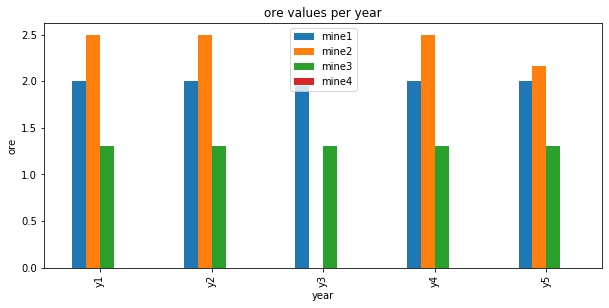

In [25]:
# import matplotlib library for visualization
import matplotlib.pyplot as plt
# matplotlib graphics are printed -inside- the notebook
%matplotlib inline 

df_res.plot(kind="bar", figsize=(10,4.5))
plt.xlabel("year")
plt.ylabel("ore")
plt.title('ore values per year');

## Adding operational constraints.

What if we wish to add operational constraints? For example, let us forbid work on certain pairs of (mines, years). Let's see how this impacts profit.

First, we add extra constraints to forbid work on those tuples.

In [26]:
# a list of (mine, year) tuples on which work is not possible.
forced_stops = [(1, 2), (0, 1), (1, 0), (3, 2), (2, 3), (3, 4)]

mm.add_constraints(work_vars[stop_m, stop_y] == 0 
                   for stop_m, stop_y in forced_stops)
mm.print_information()

Model: mining_pandas
 - number of variables: 65
   - binary=40, integer=0, continuous=25
 - number of constraints: 77
   - linear=77
 - parameters: defaults
 - objective: maximize
 - problem type is: MILP


The previous solution does not satisfy these constraints; for example (0, 1) means mine 1 should not be worked on year 2, but it was in fact worked in the above solution.

To help CPLEX find a feasible solution, we will build a heuristic feasible solution and pass it to CPLEX.

## Using an heuristic start solution

In this section, we show how one can provide a start solution to CPLEX, based on heuristics.

First, we build a solution in which mines are worked whenever possible, that is for all couples *(m,y)* except for those in *forced_stops*.

In [27]:
# build a new, empty solution
full_mining = mm.new_solution()

# define the worked 
for m in range_mines:
    for y in range_years:
        if (m,y) not in forced_stops:
            full_mining.add_var_value(work_vars[m,y], 1)
#full_mining.display()

Then we pass this solution to the model as a MIP start solution and re-solve,
this time with CPLEX logging turned on.

In [28]:
mm.add_mip_start(full_mining)
s2 = mm.solve(log_output=True)  # turns on CPLEX logging
assert s2, "solve failed"
mm.report()

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
2 of 5 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 108.9605.
Tried aggregator 5 times.
MIP Presolve eliminated 41 rows and 29 columns.
MIP Presolve modified 23 coefficients.
Aggregator did 36 substitutions.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.18 ticks)

Root node processing (before b&c):
  Real time             =    0.02 sec. (0.27 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (0.27 ticks)
* model mining_pandas solved with objective = 157.936
*  KPI: Total Actualized Revenue   = 228.367
*  KPI: Total Actualized Royalties = 70.431


You can see in the CPLEX log above, that our MIP start solution provided a good start for CPLEX, defining an initial solution with objective 157.9355

Now we can again visualize the results with *pandas* and *matplotlib*.

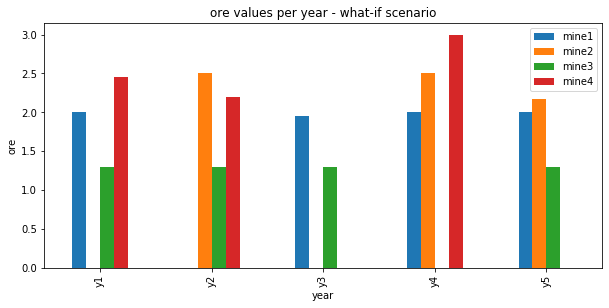

In [29]:
# Add a column to DataFrame containing 'ore' decision variables value and create a pivot table by (years, mines)
df_decision_vars['ore_values2'] = s2.get_values(df_decision_vars.ore)
df_res2 = df_decision_vars.ore_values2.unstack(level='range_mines')
df_res2.columns = mine_labels
df_res2.index = ylabels

df_res2.plot(kind="bar", figsize=(10,4.5))
plt.xlabel("year")
plt.ylabel("ore")
plt.title('ore values per year - what-if scenario');

As expected, mine1 is not worked in year 2: there is no blue bar at y2.

## Summary

You learned how to set up and use IBM Decision Optimization CPLEX Modeling for Python to formulate a Mathematical Programming model and solve it with CPLEX.

## References
* [CPLEX Modeling for Python documentation](http://ibmdecisionoptimization.github.io/docplex-doc/)
* [IBM Decision Optimization](https://www.ibm.com/analytics/decision-optimization)
* Need help with DOcplex or to report a bug? Please go [here](https://stackoverflow.com/questions/tagged/docplex).
* Contact us at dofeedback@wwpdl.vnet.ibm.com.

Copyright &copy; 2017-2019 IBM. IPLA licensed Sample Materials.